# CarND Vehicle Detection

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# find factors automatically
def factorsFind(num, prefer=None):
    if prefer is not None:
        bestDivider = prefer
        return bestDivider, int(num/bestDivider)
    bestDivider = 1
    for i in range(2,int(num/2)):
        if num%i == 0:
            bestDivider = i
    return bestDivider, int(num/bestDivider)

In [3]:
# read data directories
import glob
vehiclesDataset = glob.glob('./vehicles/vehicles/*/*.png')
nonvehicleDataset = glob.glob('./non-vehicles/non-vehicles/*/*.png')

In [4]:
# load images
import cv2
import numpy as np
import matplotlib.image as mpimg
def loadImg(imgLoc):
    image = cv2.imread(imgLoc)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255.
    if (image is None):
        print(imgLoc)
    return image
numSample = 20
vehicles = np.array([loadImg(imgLoc) for imgLoc in vehiclesDataset[0:numSample]], dtype=np.float32)
nonVehicles = np.array([loadImg(imgLoc) for imgLoc in nonvehicleDataset[0:numSample]], dtype=np.float32)

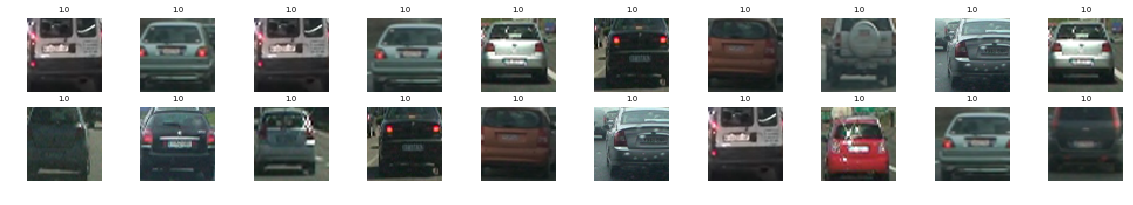

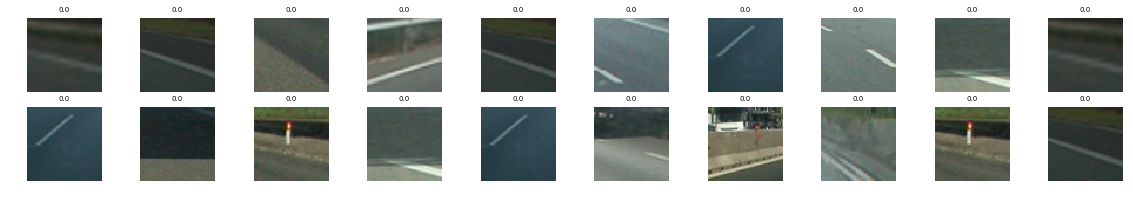

In [5]:
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(12,3), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize+1):
        img = figure.add_subplot(factors[0],factors[1],i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image+thr)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
factors = factorsFind(numSample, 10)[::-1]
plotSpecialTool(vehicles,np.ones(len(vehicles)),samples2Visualize=numSample,factors=factors, figsize=(20,3),thr=0.0,grayFlag=False) 
plotSpecialTool(nonVehicles,np.zeros(len(nonVehicles)),samples2Visualize=numSample,factors=factors, figsize=(20,3),thr=0.0,grayFlag=False) 

In [6]:
# this functions was provided during the course as quiz
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256), moreDetail=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if moreDetail == True:
        return hist_features, bin_centers, channel1_hist, channel2_hist, channel3_hist
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        feature_image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(feature_image, eval('cv2.COLOR_RGB2{}'.format(color_space)))  

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # If x and/or y start/stop positions not defined, set to image size
    if (x_start_stop[0] is None) or (x_start_stop[1] is None):
        x_start_stop = [0,img.shape[1]]
    if (y_start_stop[0] is None) or (y_start_stop[1] is None):
        y_start_stop = [0,img.shape[0]]
    # Compute the span of the region to be searched   
    xSpan = x_start_stop[1] - x_start_stop[0]
    ySpan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nxPixPerStep = np.int(xy_window[0]*(1 - xy_overlap[0]))
    nyPixPerStep = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nxWindows = np.int(xSpan/nxPixPerStep) - 1
    nyWindows = np.int(ySpan/nyPixPerStep) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(nyWindows):
        for xs in range(nxWindows):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
            # Calculate window position
            startx = xs*nxPixPerStep + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*nyPixPerStep + y_start_stop[0]
            endy = starty + xy_window[1]
        # Calculate each window position
        # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = img
    if color_space != 'RGB':
            feature_image = cv2.cvtColor(feature_image, eval('cv2.COLOR_RGB2{}'.format(color_space)))  
            
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## HOG Feature Visualize - Channel 0

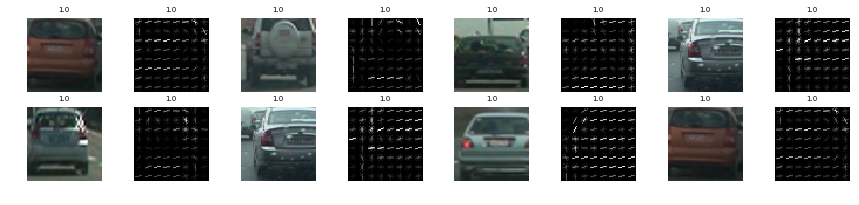

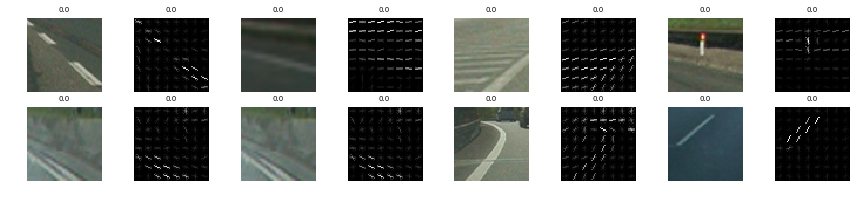

In [7]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
numSample = 8
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(12,3), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize*2,2):
        img = figure.add_subplot(factors[0],factors[1]*2,i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        _, imageOut = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image+thr)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
        
        img = figure.add_subplot(factors[0],factors[1]*2,i+1)
        plt.imshow(imageOut, cmap=plt.get_cmap('gray'))
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
factors = factorsFind(numSample,4)[::-1]
plotSpecialTool(vehicles,np.ones(len(vehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 
plotSpecialTool(nonVehicles,np.zeros(len(nonVehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 

## HOG Feature Visualize - Channel 1

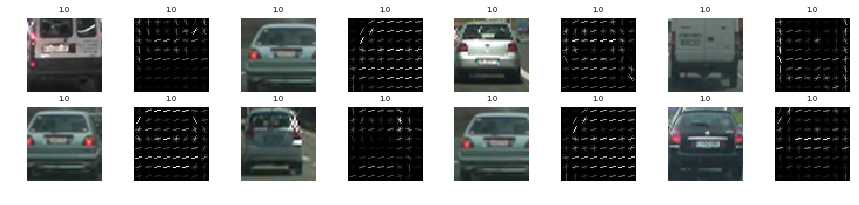

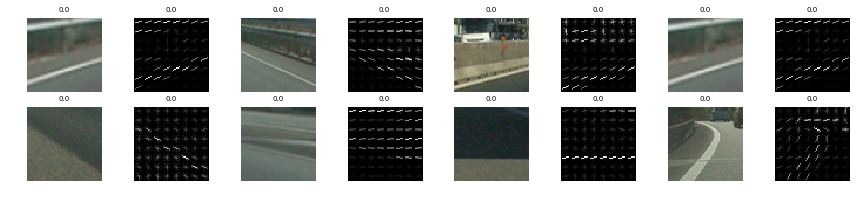

In [8]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
numSample = 8
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(12,3), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize*2,2):
        img = figure.add_subplot(factors[0],factors[1]*2,i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        _, imageOut = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image+thr)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
        
        img = figure.add_subplot(factors[0],factors[1]*2,i+1)
        plt.imshow(imageOut, cmap=plt.get_cmap('gray'))
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
factors = factorsFind(numSample,4)[::-1]
plotSpecialTool(vehicles,np.ones(len(vehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 
plotSpecialTool(nonVehicles,np.zeros(len(nonVehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 

## HOG Feature Visualize - Channel 2

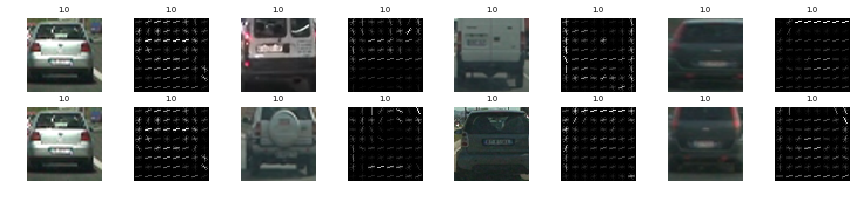

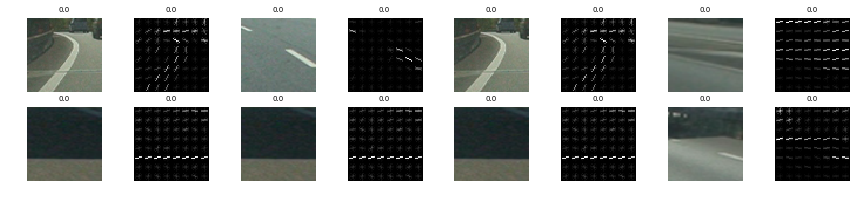

In [9]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
numSample = 8
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(12,3), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize*2,2):
        img = figure.add_subplot(factors[0],factors[1]*2,i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        _, imageOut = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image+thr)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
        
        img = figure.add_subplot(factors[0],factors[1]*2,i+1)
        plt.imshow(imageOut, cmap=plt.get_cmap('gray'))
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
factors = factorsFind(numSample,4)[::-1]
plotSpecialTool(vehicles,np.ones(len(vehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 
plotSpecialTool(nonVehicles,np.zeros(len(nonVehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 

## Histogram Feature

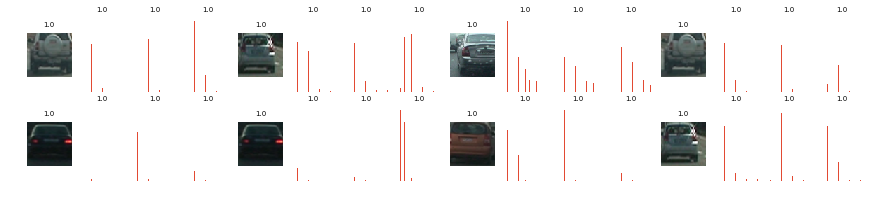

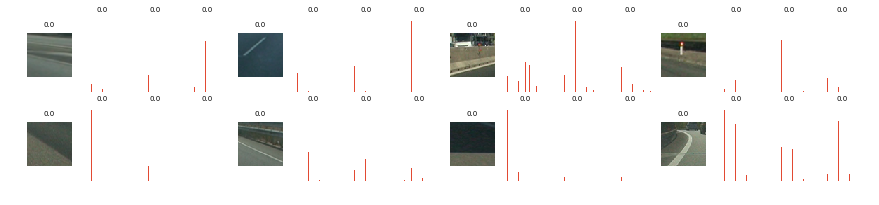

In [10]:
hist_bins = 32    # Number of histogram bins
numSample = 8
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(12,3), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    moreView = 4
    for i in range(1,samples2Visualize*moreView,moreView):
        img = figure.add_subplot(factors[0],factors[1]*moreView,i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        imageOut, binCenter, ch1, ch2, ch3 = color_hist(image*255., nbins=hist_bins, moreDetail= True)
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image+thr)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
        
        # print(ch1, ch2, ch3)
        
        img = figure.add_subplot(factors[0],factors[1]*moreView,i+1)
        plt.bar(binCenter,ch1[0])
        img.set_title(labels[imgID],fontsize=7)
        plt.xlim(0, 256)
        plt.axis('off')
        
        img = figure.add_subplot(factors[0],factors[1]*moreView,i+2)
        plt.bar(binCenter,ch2[0])
        img.set_title(labels[imgID],fontsize=7)
        plt.xlim(0, 256)
        plt.axis('off')
        
        img = figure.add_subplot(factors[0],factors[1]*moreView,i+3)
        plt.bar(binCenter,ch3[0])
        img.set_title(labels[imgID],fontsize=7)
        plt.xlim(0, 256)
        plt.axis('off')
        
factors = factorsFind(numSample,4)[::-1]
plotSpecialTool(vehicles,np.ones(len(vehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 
plotSpecialTool(nonVehicles,np.zeros(len(nonVehicles)),samples2Visualize=numSample,factors=factors, figsize=(15,3),thr=0.0,grayFlag=False) 

In [11]:
# extract features
color_space = 'YCrCb' #HSV:99 # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


# read vehicles
carFeatures = extract_features(vehiclesDataset, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# read non-vehicles
notcarFeatures = extract_features(nonvehicleDataset, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [12]:
print('Number of Samples for each class: ',len(carFeatures), len(notcarFeatures), 'So dataset is balanced.')
print('Number of Features for each class: ',carFeatures[0].shape, notcarFeatures[0].shape)

Number of Samples for each class:  8792 8968 So dataset is balanced.
Number of Features for each class:  (8460,) (8460,)


In [13]:
# combine samples
X = np.concatenate((carFeatures, notcarFeatures))
y = np.concatenate(( np.ones(len(carFeatures)), np.zeros(len(notcarFeatures)) ))

In [14]:
print(X.shape, y.shape)

(17760, 8460) (17760,)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print(X.min(), X.max())
xScaler = StandardScaler().fit(X) # for future use
X = xScaler.transform(X)
print(X.min(), X.max())
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))

0.0 4096.0
-14.1378270242 42.0542224183


In [16]:
print(xTrain.shape, yTrain.shape)
print(xTest.shape, yTest.shape)

(14208, 8460) (14208,)
(3552, 8460) (3552,)


## Train a Classifier 

In [18]:
# test various classifiers, Best Result: 99% Test acc.
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(xTrain, yTrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
# examine the results
print('Train Accuracy: ',clf.score(xTrain, yTrain), 'Test Accuracy: ', clf.score(xTest, yTest))

Train Accuracy:  1.0 Test Accuracy:  0.990427927928


In [121]:
from sklearn.metrics import confusion_matrix
yPred = clf.predict(xTest)
confusion_matrix(yTest, yPred)

array([[1796,   14],
       [  23, 1719]])

In [221]:
# make sure the accuracy is real 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=20)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.02)


## add probability prediction to the classifier

In [122]:
from sklearn.calibration import CalibratedClassifierCV
clf = LinearSVC()
clf = CalibratedClassifierCV(clf) 
clf.fit(xTrain, yTrain)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [123]:
yPred = clf.predict(xTest)
print('Train Accuracy: ',clf.score(xTrain, yTrain), 'Test Accuracy: ', clf.score(xTest, yTest))
confusion_matrix(yTest, yPred)
yProba = clf.predict_proba(xTest)
print(yProba)

Train Accuracy:  1.0 Test Accuracy:  0.990146396396
[[  9.99961055e-01   3.89450063e-05]
 [  9.99997954e-01   2.04574888e-06]
 [  9.99426572e-01   5.73427816e-04]
 ..., 
 [  5.59529189e-05   9.99944047e-01]
 [  8.60915491e-05   9.99913908e-01]
 [  9.96619901e-01   3.38009872e-03]]


## Best Model is here: SVM with Feature selector and probability output

In [17]:
# feature selection
from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(clf, prefit=True)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l2", dual=False))),
  ('classification', LinearSVC())
])
clf = CalibratedClassifierCV(clf) 
clf.fit(xTrain, yTrain)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        prefit=False, thresh...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
            cv=3, method='sigmoid')

In [19]:
# examine the results
print('Train Accuracy: ',clf.score(xTrain, yTrain), 'Test Accuracy: ', clf.score(xTest, yTest))

Train Accuracy:  1.0 Test Accuracy:  0.990427927928


In [20]:
from sklearn.metrics import confusion_matrix
yPred = clf.predict(xTest)
confusion_matrix(yTest, yPred)

array([[1757,   10],
       [  24, 1761]])

In [21]:
yProba = clf.predict_proba(xTest)
print(yProba)

[[  2.36126923e-03   9.97638731e-01]
 [  9.99423110e-01   5.76890032e-04]
 [  9.80923253e-01   1.90767468e-02]
 ..., 
 [  4.62735220e-03   9.95372648e-01]
 [  9.81110948e-01   1.88890522e-02]
 [  9.99922549e-01   7.74510061e-05]]


## Sliding Windows

In [22]:
def processImg(image):
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    draw_image = np.copy(image)
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    #windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                    xy_window=(70, 70), xy_overlap=(0.5, 0.5))
    
    # print(windows1, windows2, (windows1+windows2))
    windows = windows1 + windows2 #+ windows3

    hot_windows = search_windows(image, windows, clf, xScaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
       
    
    return window_img

6 (3, 4)


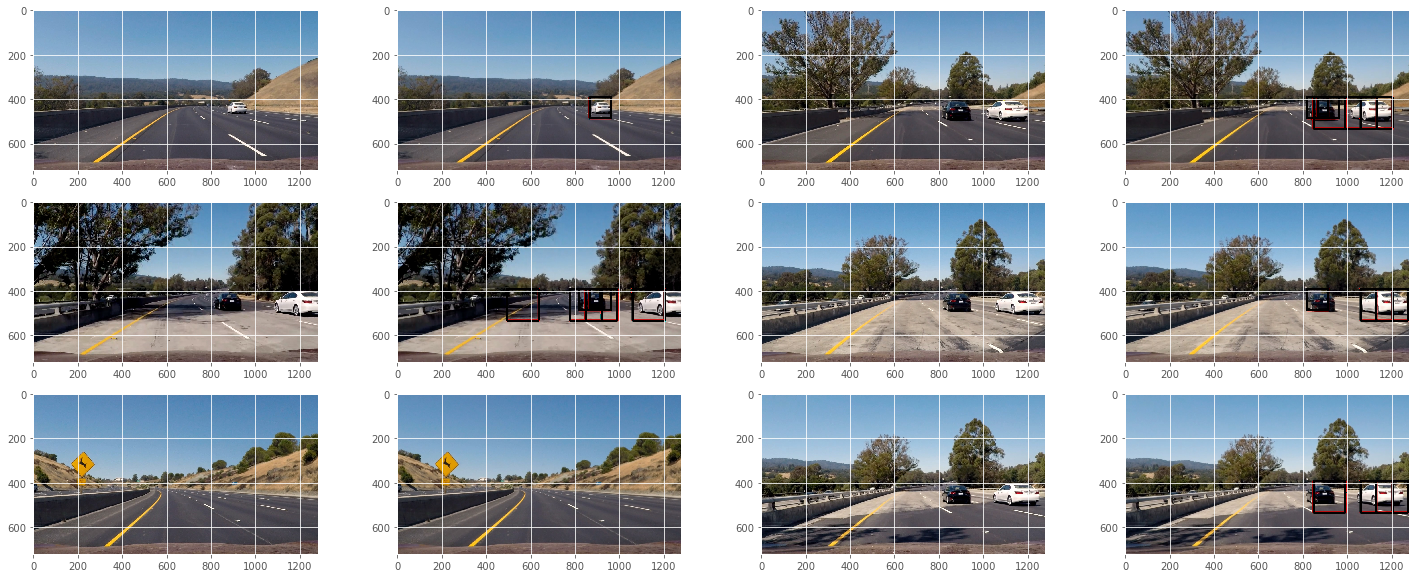

In [23]:
# Final Pipeline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5

for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale !=1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    keepAllResults = processImg(imgProcess)
   
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    #plt.figure()
    outputResult = cv2.resize(keepAllResults, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 
    #plt.savefig('output_images/'+ str(counter) + '.jpg')
    #counter += 1

In [24]:
def add_heat(heat, boxlist):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heat
    
def apply_threshold(heatmap, threshold):
    heatMap = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatMap[heatMap < threshold] = 0
    # Return thresholded map
    return heatMap

In [25]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)[0]
        
        clfProb = clf.predict_proba(test_features)[0][1]
        
        # print(prediction, clfProb)
        
        #7) If positive (prediction == 1) then save the window
        if (prediction == 1) and (clfProb > 0.65):
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [26]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # If x and/or y start/stop positions not defined, set to image size
    if (x_start_stop[0] is None) or (x_start_stop[1] is None):
        x_start_stop = [0,img.shape[1]]
    if (y_start_stop[0] is None) or (y_start_stop[1] is None):
        y_start_stop = [0,img.shape[0]]
    # Compute the span of the region to be searched   
    xSpan = x_start_stop[1] - x_start_stop[0]
    ySpan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nxPixPerStep = np.int(xy_window[0]*(1 - xy_overlap[0]))
    nyPixPerStep = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nxWindows = np.int(xSpan/nxPixPerStep) - 1
    nyWindows = np.int(ySpan/nyPixPerStep) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(nyWindows):
        for xs in range(nxWindows):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
            # Calculate window position
            startx = xs*nxPixPerStep + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*nyPixPerStep + y_start_stop[0]
            endy = starty + xy_window[1]
        # Calculate each window position
        # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

(720, 1280, 3)


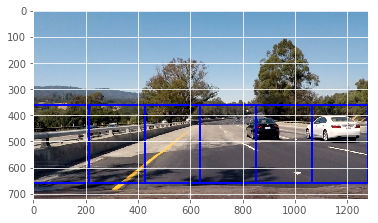

In [131]:
img = cv2.imread(filename)
image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(image.shape)
y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-20] 
window_img = np.copy(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/3), 300), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=6)  

outputResult = cv2.resize(window_img, (img.shape[1], img.shape[0]))
plt.imshow(outputResult) 

(720, 1280, 3)


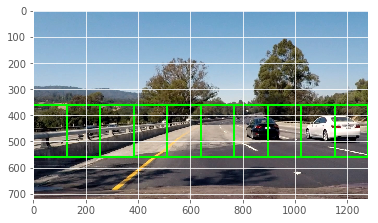

In [132]:
img = cv2.imread(filename)
image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(image.shape)
y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-110] 
window_img = np.copy(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/5), 200), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(window_img, windows, color=(0, 255, 0), thick=6)  

outputResult = cv2.resize(window_img, (img.shape[1], img.shape[0]))
plt.imshow(outputResult) 

(720, 1280, 3)


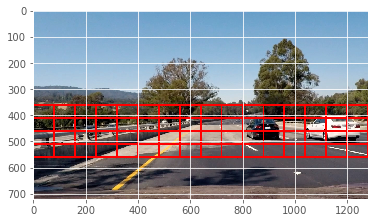

In [36]:
img = cv2.imread(filename)
image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(image.shape)
y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-140] 
window_img = np.copy(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/8), 100), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)  

outputResult = cv2.resize(window_img, (img.shape[1], img.shape[0]))
plt.imshow(outputResult) 

(720, 1280, 3)


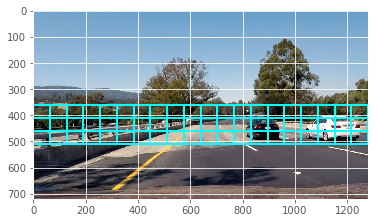

In [37]:
img = cv2.imread(filename)
image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(image.shape)
y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-200] 
window_img = np.copy(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/10), 100), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(window_img, windows, color=(0, 255, 255), thick=6)  

outputResult = cv2.resize(window_img, (img.shape[1], img.shape[0]))
plt.imshow(outputResult) 

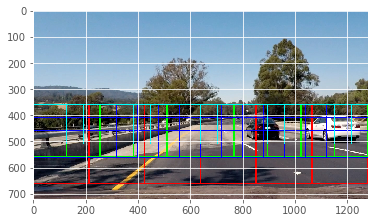

In [38]:
img = cv2.imread(filename)
image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
window_img = np.copy(image)

y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-20] 
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/3), 300), xy_overlap=(0.5, 0.5))
    
y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-110] 
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/5), 200), xy_overlap=(0.5, 0.5))

y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-140] 
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/8), 100), xy_overlap=(0.5, 0.5))

y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-200] 
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(np.int(image.shape[1]/10), 100), xy_overlap=(0.5, 0.5))

windows = windows1 + windows2 + windows3 + windows4

window_img = draw_boxes(window_img, windows1, color=(255, 0, 0), thick=4)  
window_img = draw_boxes(window_img, windows2, color=(0, 255, 0), thick=3)  
window_img = draw_boxes(window_img, windows3, color=(0, 0, 255), thick=2)  
window_img = draw_boxes(window_img, windows4, color=(0, 255, 255), thick=1)  


outputResult = cv2.resize(window_img, (img.shape[1], img.shape[0]))
plt.imshow(outputResult) 

In [27]:
def processImg(image):
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    draw_image = np.copy(image)
    
    
    
    '''    y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-20] 
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/3), 300), xy_overlap=(0.8, 0.8))

    y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-110] 
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/5), 200), xy_overlap=(0.7, 0.7))

    y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-140] 
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/8), 100), xy_overlap=(0.75, 0.75))

    y_start_stop = [np.int(image.shape[0]/2)+10, image.shape[0]-200] 
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/10), 70), xy_overlap=(0.85, 0.85))
    
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-200] 
    windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/15), 60), xy_overlap=(0.75, 0.75))

    windows = windows1 + windows2  + windows3  + windows4 + windows5'''
    
    
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(58, 58), xy_overlap=(0.5, 0.5))
    
    # print(windows1, windows2, (windows1+windows2))
    windows = windows1 + windows2 + windows3

    hot_windows = search_windows(image, windows, clf, xScaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
    # return window_img
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)    
    
    
    heatmapThr = apply_threshold(heatmap, 2)
    final_map = np.clip(heatmapThr - 2, 0, 255)
    
    
    return window_img, heatmap, heatmapThr, final_map


6 (3, 4)


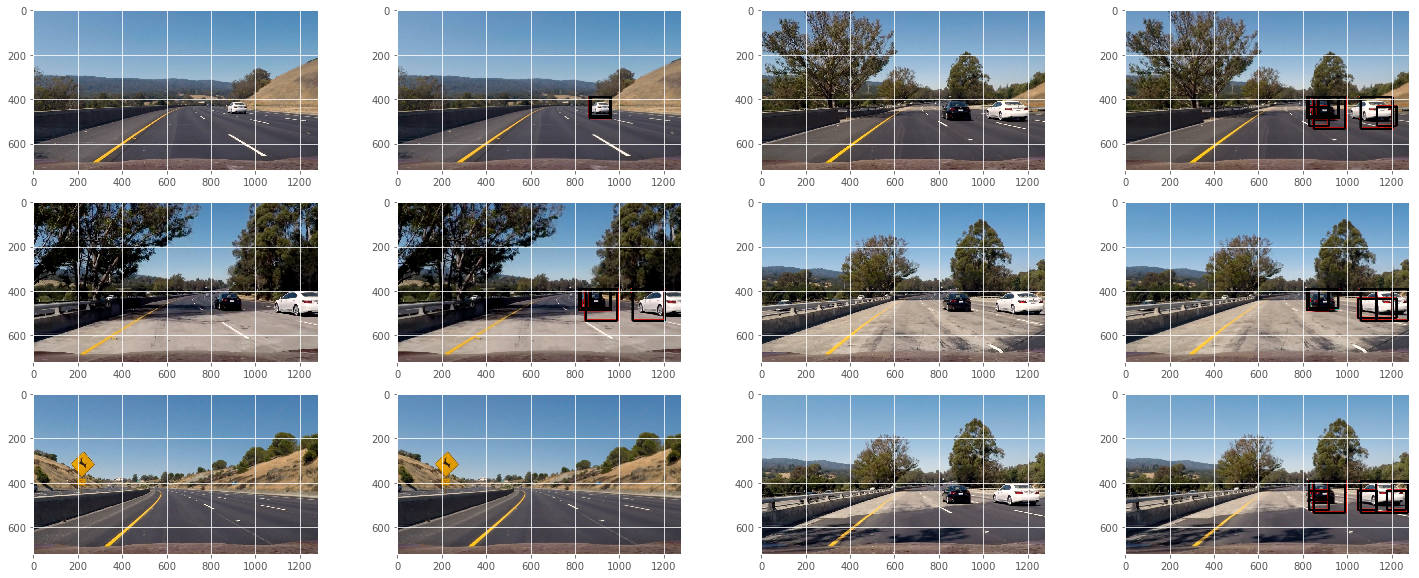

In [28]:
# Final Pipeline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5

for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    keepAllResults,_,_,_ = processImg(imgProcess)
   
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    #plt.figure()
    outputResult = cv2.resize(keepAllResults, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 
    #plt.savefig('output_images/'+ str(counter) + '.jpg')
    #counter += 1

6 (3, 4)


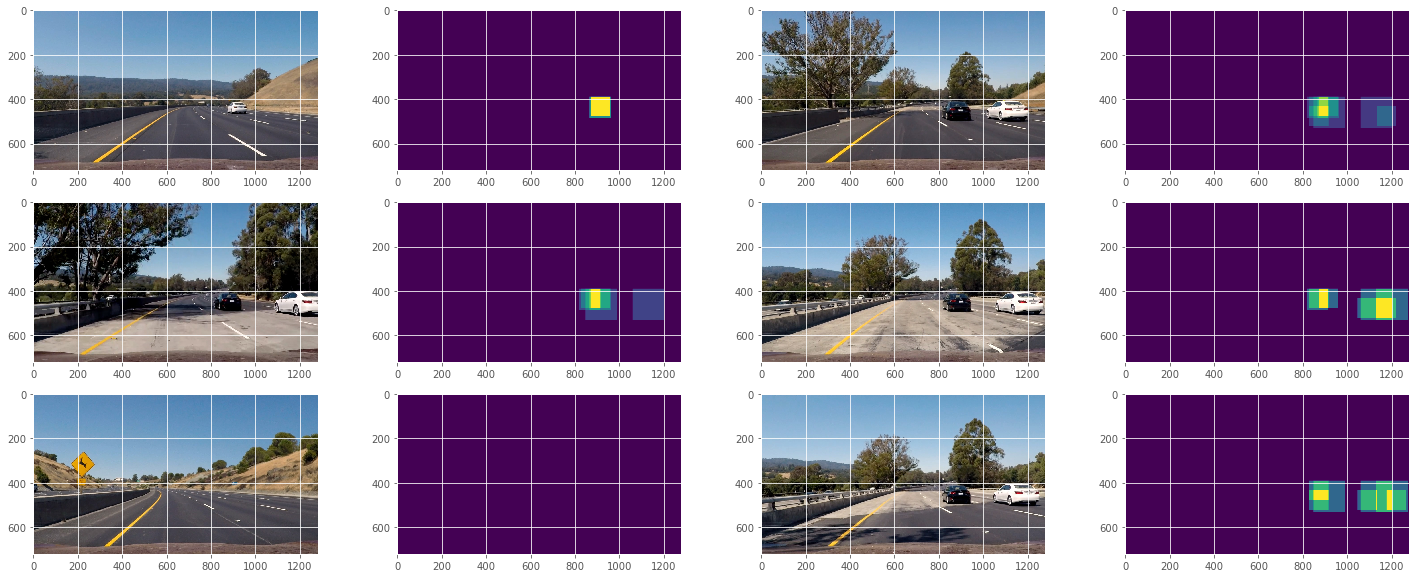

In [29]:
# Final Pipeline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5
for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    window_img, heatmap, heatmapThr, final_map = processImg(imgProcess)
        
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    #plt.figure()
    outputResult = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 
    #plt.savefig('output_images/'+ str(counter) + '.jpg')
    #counter += 1


6 (3, 4)


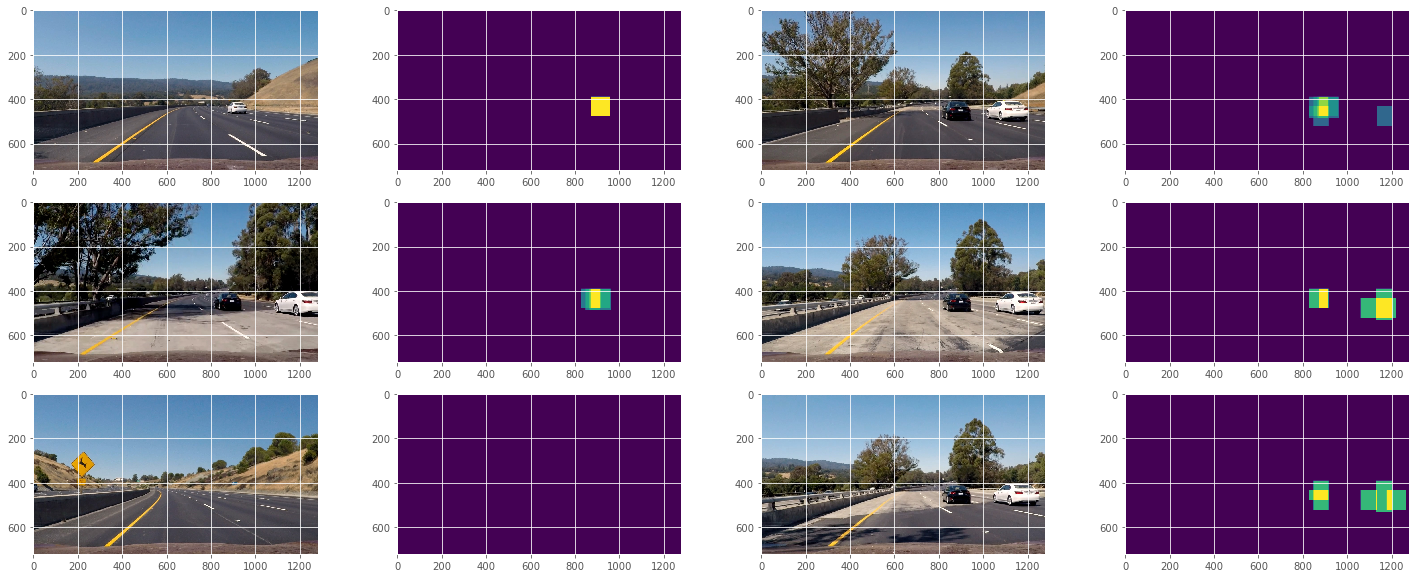

In [30]:
# Final Pipeline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5
for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    window_img, heatmap, heatmapThr, final_map = processImg(imgProcess)
        
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    #plt.figure()
    outputResult = cv2.resize(heatmapThr, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 
    #plt.savefig('output_images/'+ str(counter) + '.jpg')
    #counter += 1

6 (3, 4)


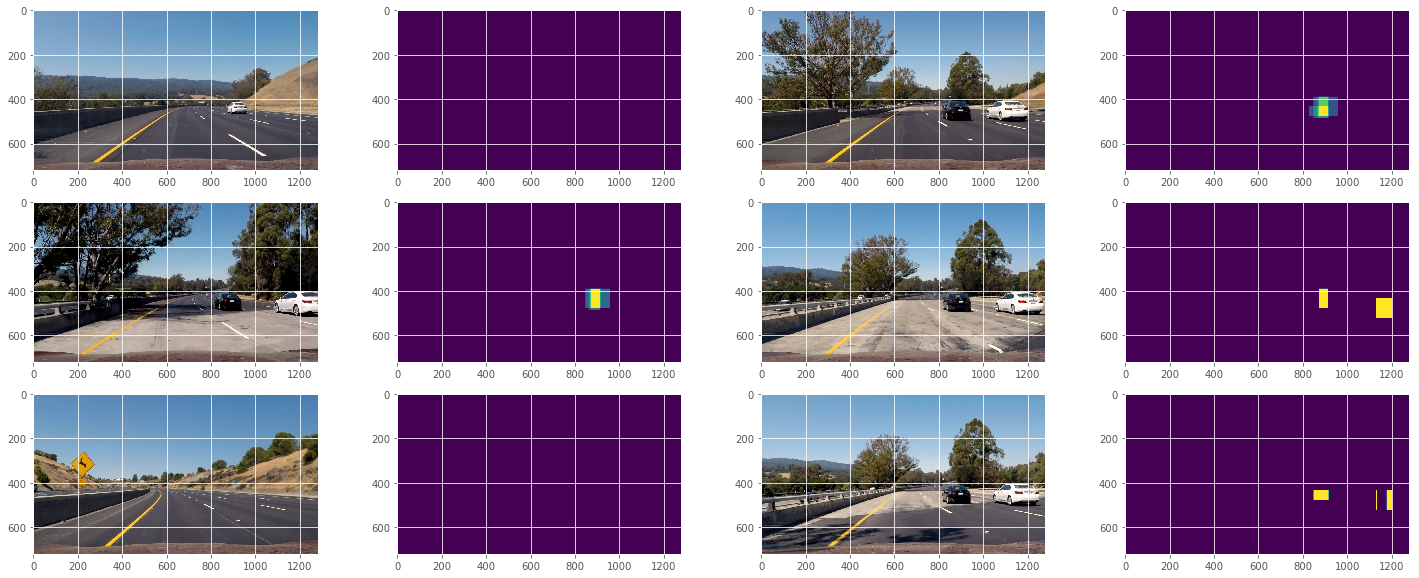

In [31]:
# Final Pipeline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5
for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    window_img, heatmap, heatmapThr, final_map = processImg(imgProcess)
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    #plt.figure()
    outputResult = cv2.resize(final_map, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 
    #plt.savefig('output_images/'+ str(counter) + '.jpg')
    #counter += 1

In [32]:
from scipy.ndimage.measurements import label
from skimage.measure import regionprops #, label

def drawLabeledBBoxes(img, labels, scale):
    for carNumber in range(1, labels[1]+1):
        nonzero = (labels[0] == carNumber).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        p0l,p0r = bbox[0]
        p1l,p1r = bbox[1]
        p0l = np.int(p0l * scale)
        p0r = np.int(p0r * scale)
        p1l = np.int(p1l * scale)
        p1r = np.int(p1r * scale)
        cv2.rectangle(img, (p0l, p0r), (p1l, p1r), (0,0,255), 3)
        
        # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

def boundingBox(heatMap):
    allBoxes = []
    labeled = label(heatMap)    
    regionProps = regionprops(labeled)
    for region in regionProps:
        #print(region.area)
        if region.area > 1500:
            properties = region.bbox
            #print(properties)
            # (min_row, min_col, max_row, max_col)
            #print(properties[0])
            #print(np.abs(properties[0]-properties[2]), np.abs(properties[3]-properties[1]))
            if (np.abs(properties[0]-properties[2]) <= np.abs(properties[3]-properties[1])) + 20:
                allBoxes.append(((properties[1], properties[0]), (properties[3], properties[2])))
    return allBoxes


In [33]:
def processImg(image):
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    draw_image = np.copy(image)
    
    
    
    '''    y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-20] 
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/3), 300), xy_overlap=(0.8, 0.8))

    y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-110] 
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/5), 200), xy_overlap=(0.7, 0.7))

    y_start_stop = [np.int(image.shape[0]/2), image.shape[0]-140] 
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/8), 100), xy_overlap=(0.75, 0.75))

    y_start_stop = [np.int(image.shape[0]/2)+10, image.shape[0]-200] 
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/10), 70), xy_overlap=(0.85, 0.85))
    
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-200] 
    windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(np.int(image.shape[1]/15), 60), xy_overlap=(0.75, 0.75))

    windows = windows1 + windows2  + windows3  + windows4 + windows5'''
    
    
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(58, 58), xy_overlap=(0.5, 0.5))
    
    # print(windows1, windows2, (windows1+windows2))
    windows = windows1 + windows2 + windows3

    hot_windows = search_windows(image, windows, clf, xScaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    heatmapThr = apply_threshold(heatmap, 2)
    final_map = np.clip(heatmapThr - 2, 0, 255)
    
    
    #finalRes = boundingBox(heatmap)
    
    return window_img, heatmap, heatmapThr, final_map

6 (3, 4)


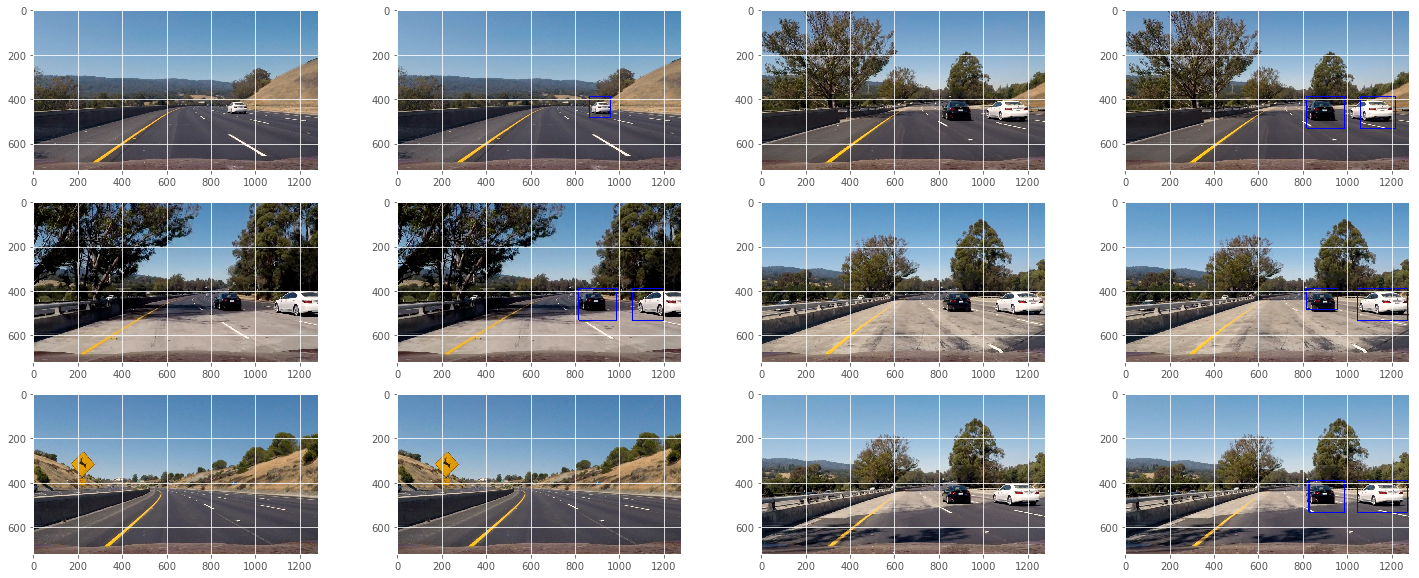

In [34]:
# Final Pipeline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5
for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
        
    window_img, heatmap, heatmapThr, final_map = processImg(imgProcess)
        
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    
    labels = label(heatmap)
    imageOut = drawLabeledBBoxes(np.copy(img), labels, scale)

    '''imageOut = np.copy(img)
    for box in finalRes:
        p0l,p0r = box[0]
        p1l,p1r = box[1]
        p0l = np.int(p0l * scale)
        p0r = np.int(p0r * scale)
        p1l = np.int(p1l * scale)
        p1r = np.int(p1r * scale)
        cv2.rectangle(imageOut, (p0l, p0r), (p1l, p1r), (0,0,255), 3)'''

    
    #plt.figure()
    outputResult = cv2.resize(imageOut, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 
    #plt.savefig('output_images/'+ str(counter) + '.jpg')
    #counter += 1

In [35]:
def videoProcess(img):    
    scale = 1.5

    draw_image = np.copy(img)
    image = img.astype(np.float32)/255.
    
    if scale != 1:
        image = cv2.resize(image, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    
    
    
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(58, 58), xy_overlap=(0.5, 0.5))
    
    # print(windows1, windows2, (windows1+windows2))
    windows = windows1 + windows2 + windows3

    hot_windows = search_windows(image, windows, clf, xScaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    
    #finalRes = boundingBox(heatmap)
    
    #for box in finalRes:
        #cv2.rectangle(imgOutput, box[0], box[1], (1,255,1), 3)
        
        
    labels = label(heatmap)
    imageOut = drawLabeledBBoxes(np.copy(img), labels, scale)
    
    return imageOut

In [57]:
class vehicleTracker():
    
    avgFramesMaximum = 10 # limit the maximum frame check
    def __init__(self):
        self.frame = 0
        self.currentHeatmap = 0
        self.previousHeatmap = 0 
        self.avgHeatmap = 0
        
    def setFrame(self, frame):
        self.frame = frame
        self.update()
        
    def returnFrame(self):
        return self.frame
    
    def setHeatmap(self, heatmap):
        self.previousHeatmap = self.currentHeatmap
        self.currentHeatmap = heatmap
        self.add2avgHeatmap()
        # self.returnAvgHeatmap()
        
    def returnAvgHeatmap(self):
        #print(self.avgHeatmap)
        return self.avgHeatmap
    
    def add2avgHeatmap(self):
        # print(self.avgHeatmap.shape, self.currentHeatmap.shape)
        self.currentHeatmap = apply_threshold(self.currentHeatmap, 2)
        self.avgHeatmap = (0.75*self.avgHeatmap + self.currentHeatmap) # 0.8 * self.avgHeatmap + 
        self.avgHeatmap = apply_threshold(self.avgHeatmap, 2)
        
    def update(self):
        self.currentHeatmap = np.zeros_like(self.frame[:,:,0]).astype(np.float)
        self.previousHeatmap =np.zeros_like(self.frame[:,:,0]).astype(np.float)
        self.avgHeatmap = np.zeros_like(self.frame[:,:,0]).astype(np.float)

In [58]:
vehicleTrack = vehicleTracker()
scale = 1.5
image = img.astype(np.float32)/255.
if scale != 1:
    image = cv2.resize(image, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
vehicleTrack.setFrame(image)
def videoProcess(img):    
    scale = 1.5

    draw_image = np.copy(img)
    image = img.astype(np.float32)/255.
    
    if scale != 1:
        image = cv2.resize(image, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    
    
    
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(58, 58), xy_overlap=(0.5, 0.5))
    
    # print(windows1, windows2, (windows1+windows2))
    windows = windows1 + windows2 + windows3

    hot_windows = search_windows(image, windows, clf, xScaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    
    #labels = label(heatmap)
    #print(labels)
    
    vehicleTrack.setHeatmap(heatmap)
    heatmap = vehicleTrack.returnAvgHeatmap()
    # print(heatmap, heatmapAVG)
    
    #finalRes = boundingBox(heatmap)
    
    #for box in finalRes:
        #cv2.rectangle(imgOutput, box[0], box[1], (1,255,1), 3)
        
    labels = label(heatmap)
    #print(labels)
    #if labels[1]==2:
    imageOut = drawLabeledBBoxes(np.copy(img), labels, scale)
    #else:
        #imageOut = np.copy(img)
    return imageOut

In [59]:
# process videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# initiate instance
#vehicleTrackerIns = vehicleTracker()

# video processing
output = 'output_videos/testVideoMine.mp4'
clip = VideoFileClip("test_video.mp4")
clip = clip.fl_image(videoProcess)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/testVideoMine.mp4
[MoviePy] Writing video output_videos/testVideoMine.mp4


 97%|█████████▋| 38/39 [01:21<00:02,  2.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/testVideoMine.mp4 



In [60]:
vehicleTrack = vehicleTracker()
scale = 1.5
image = img.astype(np.float32)/255.
if scale != 1:
    image = cv2.resize(image, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
vehicleTrack.setFrame(image)
# process videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# initiate instance
# vehicleTrackerIns = vehicleTracker()

# video processing
output = 'output_videos/p5VideoMine.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(videoProcess)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/p5VideoMine.mp4
[MoviePy] Writing video output_videos/p5VideoMine.mp4


100%|█████████▉| 1260/1261 [46:04<00:02,  2.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/p5VideoMine.mp4 



In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML 
output = 'output_videos/project.mp4' 
clip = VideoFileClip("project_video.mp4")  # for debugging
clip.write_images_sequence('videoSeq/frame%04d.jpeg')

6 (3, 4)


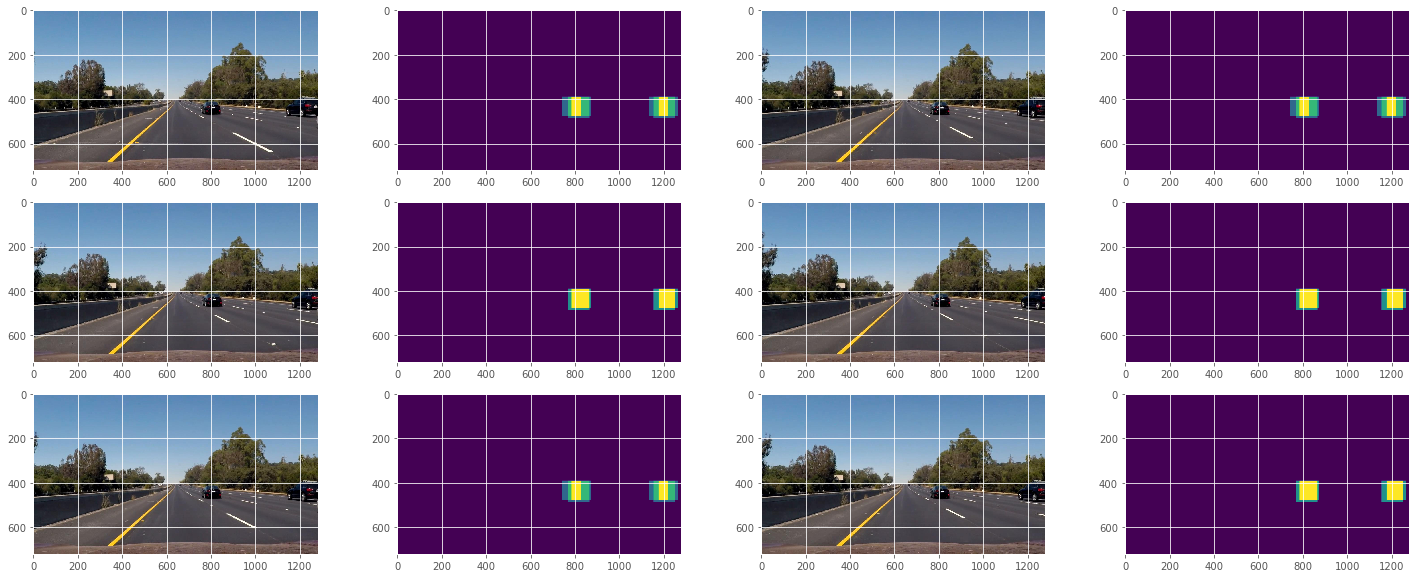

In [70]:
# videoSequence
# Final Pipeline
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = 'videoSequence/*.jpeg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5
for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
        
    window_img, heatmap, heatmapThr, final_map = processImg(imgProcess)
        
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    
    labels = label(heatmap)
    imageOut = drawLabeledBBoxes(np.copy(img), labels, scale)
    
    outputResult = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 

6 (3, 4)


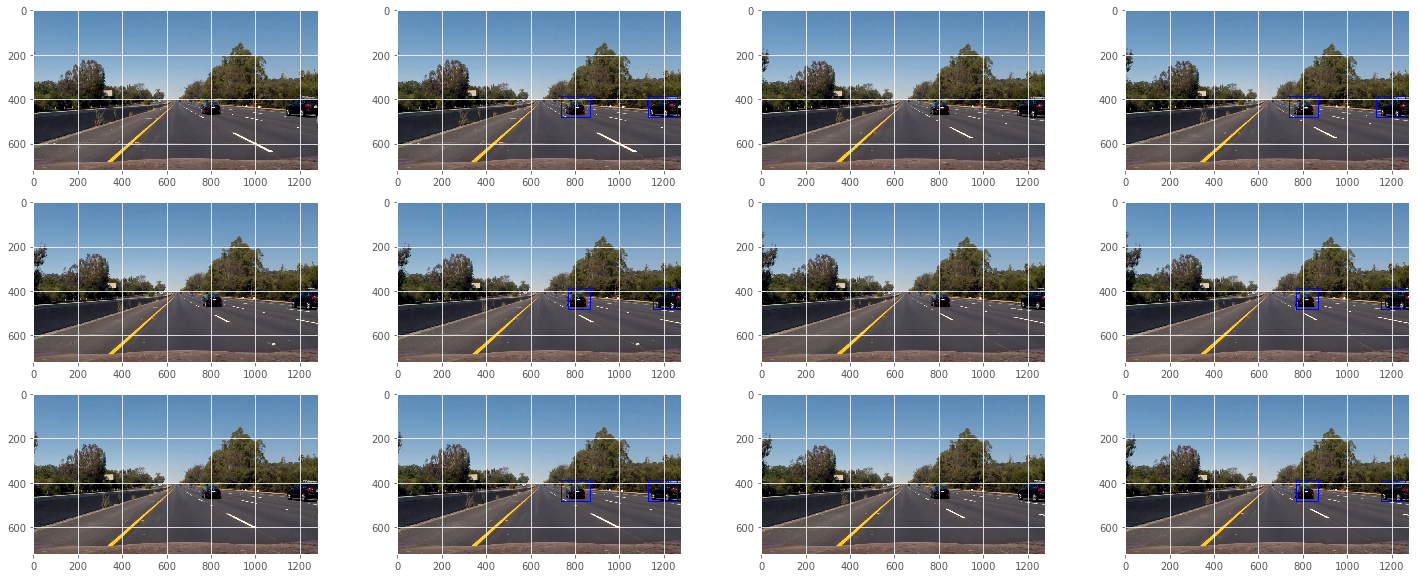

In [69]:
# videoSequence
# Final Pipeline
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = 'videoSequence/*.jpeg'
globDir = glob.glob(directory)
factors = factorsFind(len(globDir)*2,3)
print(len(globDir),factors)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5
for filename in globDir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    
    imgProcess = img.astype(np.float32)/255
    
    if scale != 1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
        
    window_img, heatmap, heatmapThr, final_map = processImg(imgProcess)
        
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(img) # plot original image  
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    
    
    labels = label(heatmap)
    imageOut = drawLabeledBBoxes(np.copy(img), labels, scale)
    
    outputResult = cv2.resize(imageOut, (img.shape[1], img.shape[0]))
    plt.imshow(outputResult) 